# Monotone least squares 
The objective of this example is to show how to build a transport map to solve monotone regression problems using MParT.

## Problem formulation
One direct use of the monotonicity property given by the transport map approximation to model monotone functions from noisy data. This is called isotonic regression and can be solved in our setting by minimizing the least squares objective function

$$
J(\mathbf{w})= \frac{1}{2} \sum_{i=1}^N \left(S(x^i;\mathbf{w}) - y^i \right)^2,
$$

where $S$ is a monotone 1D map with parameters (polynomial coefficients) $\mathbf{w}$ and $y^i$ are noisy observations.   To solve for the map parameters that minimize this objective we will use a gradient-based optimizer.  We therefore need the gradient of the objective with respect to the map paramters.  This is given by

$$
\nabla_\mathbf{w} J(\mathbf{w})= \sum_{i=1}^N \left(S(x^i;\mathbf{w}) - y^i \right)^T\left[\nabla_\mathbf{w}S(x^i;\mathbf{w})\right]
$$

The implementation of `S(x)` we're using from MParT, provides tools for both evaluating the map to compute  $S(x^i;\mathbf{w})$ but also evaluating computing the action of  $\left[\nabla_\mathbf{w}S(x^i;\mathbf{w})\right]^T$ on a vector, which is useful for computing the gradient.   Below, these features are leveraged when defining an objective function that we then minimize with the BFGS optimizer implemented in `scipy.minimize`.

## Imports
First, import MParT and other packages used in this notebook. Note that it is possible to specify the number of threads used by MParT by setting the `KOKKOS_NUM_THREADS` environment variable **before** importing MParT.

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
os.environ['KOKKOS_NUM_THREADS'] = '8'

import mpart as mt
print('Kokkos is using', mt.Concurrency(), 'threads')
plt.rcParams['figure.dpi'] = 110

Kokkos::OpenMP::initialize WARNING: You are likely oversubscribing your CPU cores.
  process threads available :   4,  requested thread :   8


Kokkos::OpenMP::initialize WARNING: You are likely oversubscribing your CPU cores.
                                    Detected: 4 cores per node.
                                    Detected: 1 MPI_ranks per node.
                                    Requested: 8 threads per process.


Kokkos is using 8 threads


## Generate training data

### True model

Here we choose to use the step function $H(x)=\text{sgn}(x-2)+1$ as the reference monotone function. It is worth noting that this function is not strictly monotone and is only piecewise continuous.

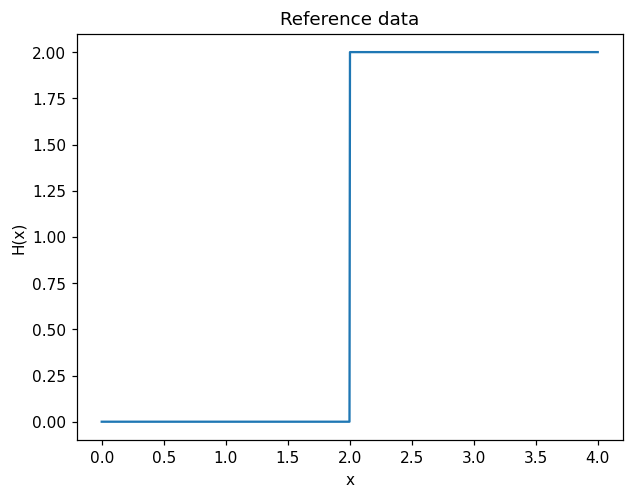

In [2]:
# variation interval
num_points = 1000
xmin, xmax = 0, 4
x = np.linspace(xmin, xmax, num_points)[None,:]

y_true = 2*(x>2)

plt.figure()
plt.title('Reference data')
plt.plot(x.flatten(),y_true.flatten())
plt.xlabel('x')
plt.ylabel('H(x)')
plt.show()

### Training data

Training data $y^i$ in the objective defined above are simulated by pertubating the reference data with a white Gaussian noise with a $0.4$ standard deviation.

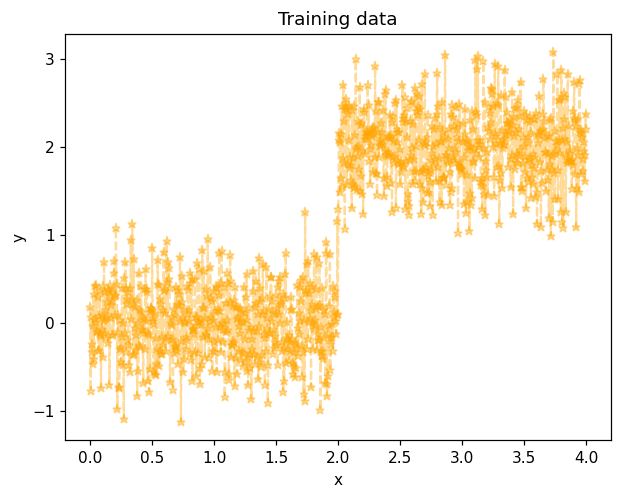

In [3]:
noisesd = 0.4

y_noise = noisesd*np.random.randn(num_points) 
y_measured = y_true + y_noise

plt.figure()
plt.title('Training data')
plt.plot(x.flatten(),y_measured.flatten(),color='orange',marker='*',linestyle='--',label='measured data', alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Map initialization

We use the previously generated data to train the 1D transport map. In 1D, the map complexity can be set via the list of multi-indices. Here, map complexity can be tuned by setting the `max_order` variable.



### Multi-index set

In [4]:
# Define multi-index set
max_order = 5
multis = np.linspace(0,max_order,6).reshape(-1,1).astype(int)
mset = mt.MultiIndexSet(multis)
fixed_mset = mset.fix(True)

# Set options and create map object
opts = mt.MapOptions()
opts.quadMinSub = 4

monotone_map = mt.CreateComponent(fixed_mset, opts)

### Plot initial approximation

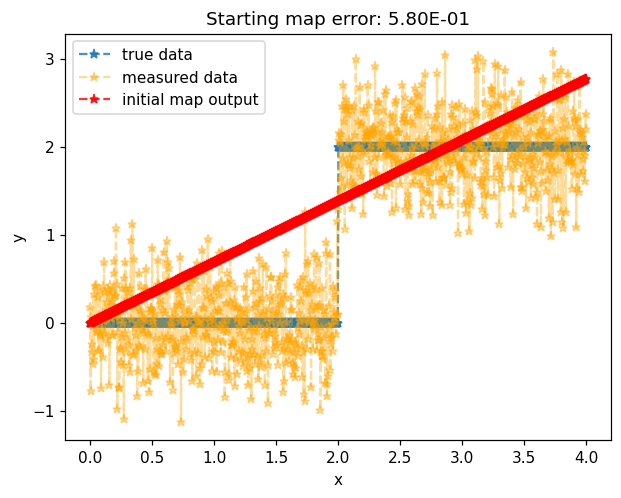

In [5]:
# Before optimization
map_of_x_before = monotone_map.Evaluate(x)
error_before = np.sum((map_of_x_before - y_measured)**2)/x.shape[1]

# Plot data and initial approximation
plt.figure()
plt.title('Starting map error: {:.2E}'.format(error_before))
plt.plot(x.flatten(),y_true.flatten(),'*--',label='true data', alpha=0.8)
plt.plot(x.flatten(),y_measured.flatten(),'*--',label='measured data',color='orange', alpha=0.4)
plt.plot(x.flatten(),map_of_x_before.flatten(),'*--',label='initial map output', color="red", alpha=0.8)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Initial map with coefficients set to zero result in the identity map.

## Transport map training

### Objective function

In [6]:
# Least squares objective
def objective(coeffs, monotone_map, x, y_measured):
    monotone_map.SetCoeffs(coeffs)
    map_of_x = monotone_map.Evaluate(x)
    return np.sum((map_of_x - y_measured)**2)/x.shape[1]

# Gradient of objective
def grad_objective(coeffs, monotone_map, x, y_measured):
    monotone_map.SetCoeffs(coeffs)
    map_of_x = monotone_map.Evaluate(x)
    return 2*np.sum(monotone_map.CoeffGrad(x, map_of_x - y_measured),1)/x.shape[1]




#### Optimization

In [7]:
# Optimize
optimizer_options={'gtol': 1e-3, 'disp': True}
res = minimize(objective, monotone_map.CoeffMap(), args=(monotone_map, x, y_measured), jac=grad_objective, method='BFGS', options=optimizer_options)

# After optimization
map_of_x_after = monotone_map.Evaluate(x)
error_after = objective(monotone_map.CoeffMap(), monotone_map, x, y_measured)

Optimization terminated successfully.
         Current function value: 0.175196
         Iterations: 51
         Function evaluations: 56
         Gradient evaluations: 56


### Plot final approximation

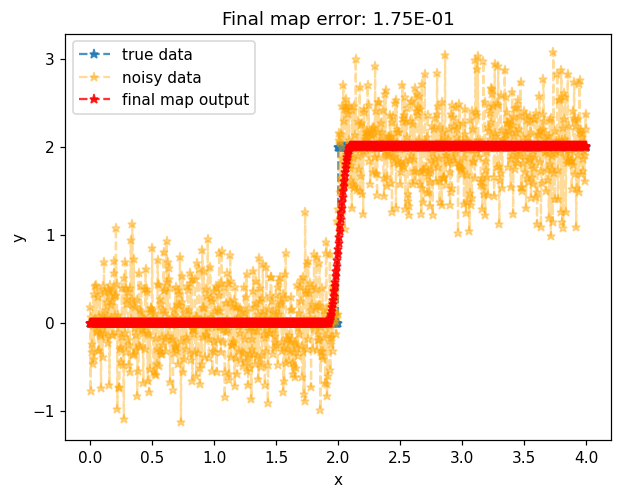

In [8]:
plt.figure()
plt.title('Final map error: {:.2E}'.format(error_after))
plt.plot(x.flatten(),y_true.flatten(),'*--',label='true data', alpha=0.8)
plt.plot(x.flatten(),y_measured.flatten(),'*--',label='noisy data', color='orange',alpha=0.4)
plt.plot(x.flatten(),map_of_x_after.flatten(),'*--',label='final map output', color="red", alpha=0.8)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Unlike the true underlying model, map approximation gives a strict coninuous monotone regression of the noisy data.